# Create Dataset RUL real: Rectifier October 2023

In [1]:
import pandas as pd
import numpy as np
from datautil import RULDataset_fast, sys_separation, plot_features, RULData_reduction,moving_average,sequential_data
from random import sample
from pickle import dump,load


### Parameters

In [11]:
# data='Rectifier'#'-Rectifier_ripple' #'-Rectifier_Vpp_No_RMS' #'-RectifierDiode_norm2' #''-RectifierDiode_norm3_100' 
# Dataset='Rectifier'# 'RectifierRUL'#   f'Capacitor{cap}'# 
# Test=''# '_Test' #
data_name='Rectifier_oct23_cap' 
problem_name='RectifierData_step10h' #

dataset_name='RUL_real_cap'

## Loading Data

In [12]:
RUL_df=pd.read_csv(f'./{data_name}/{problem_name}.csv') #without 0s
column_labels=list(RUL_df.columns.to_numpy())

In [13]:
df=RULData_reduction(RUL_df)
sys_array=df['System'].to_numpy()

In [14]:
df.to_numpy().shape

(79131, 9)

# PLot all the data

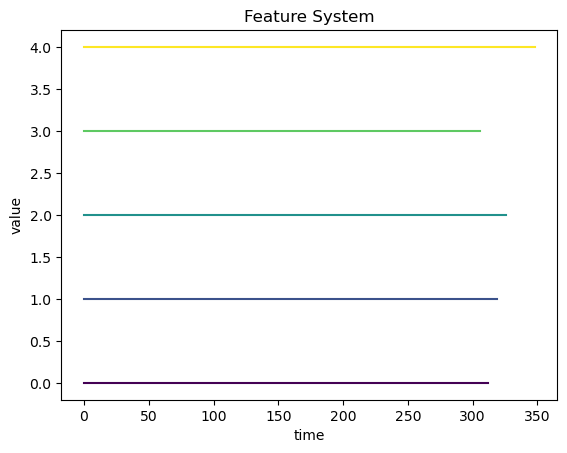

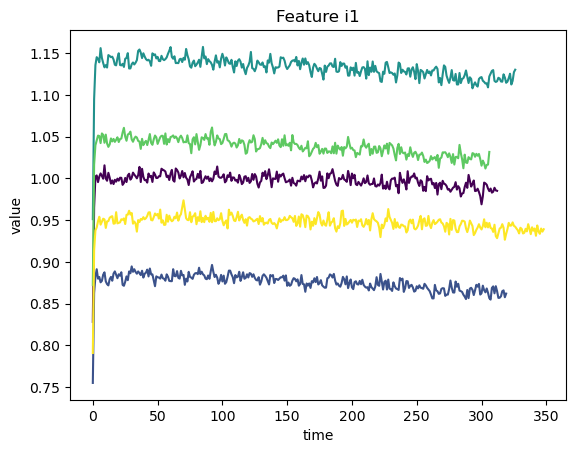

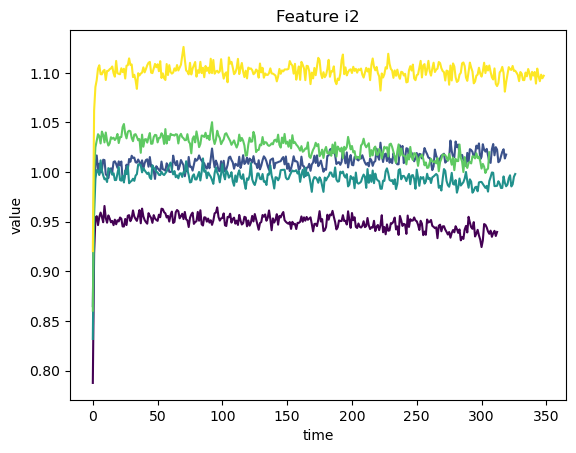

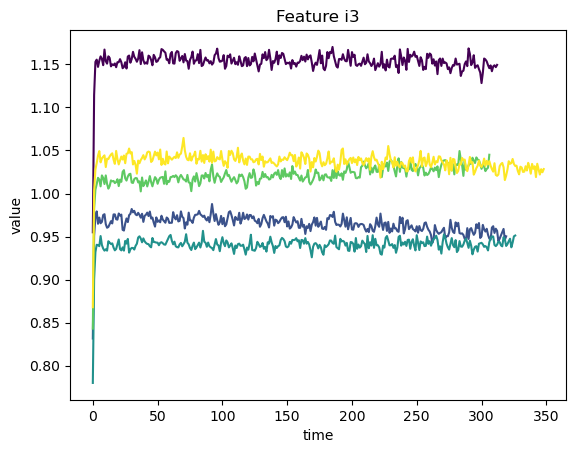

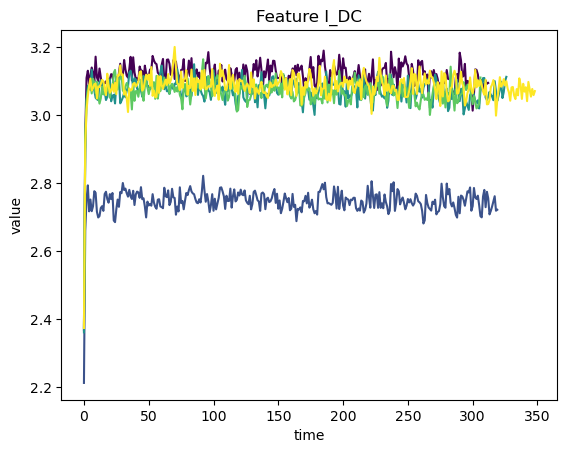

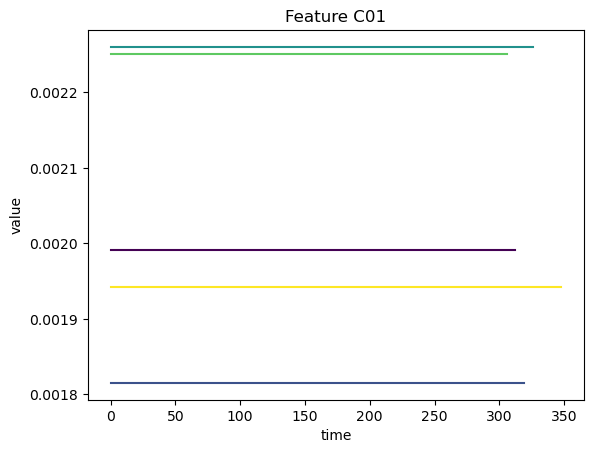

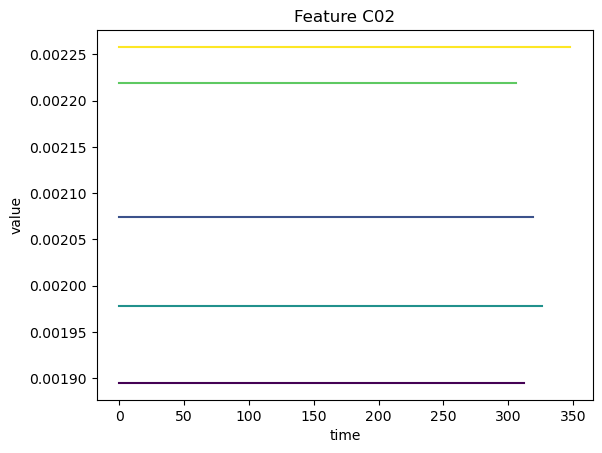

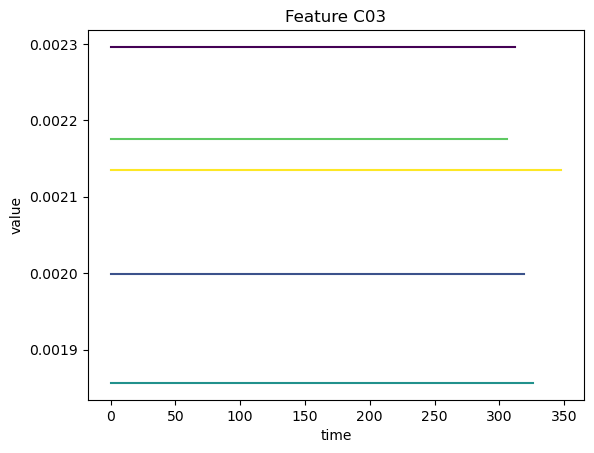

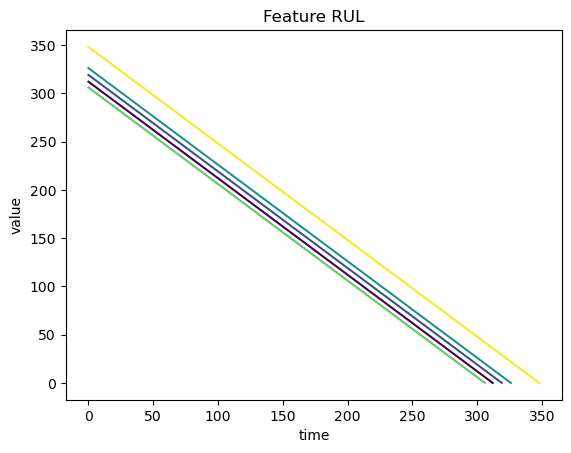

In [15]:
Data_sep=sys_separation(df.to_numpy(),sys_array,aligned='left')
plot_features(Data_sep[:5],labels=column_labels)

In [16]:
column_labels

['System', 'i1', 'i2', 'i3', 'I_DC', 'C01', 'C02', 'C03', 'RUL']

In [18]:
labels={'X':column_labels[1:8],
        'Z':[],
        'U':[],
        'Y':[column_labels[8]]}
labels

{'X': ['i1', 'i2', 'i3', 'I_DC', 'C01', 'C02', 'C03'],
 'Z': [],
 'U': [],
 'Y': ['RUL']}

In [19]:
X=df[labels['X']].to_numpy()
Y=df[labels['Y']].to_numpy()

In [20]:
X_sep=sys_separation(X,sys_array,aligned='left')
Y_sep=sys_separation(Y,sys_array,aligned='left')

# Create Dataset

In [21]:
dataset=RULDataset_fast(data=(X,np.array([]),np.array([]),Y),sys_array=sys_array,data_labels=labels,
                        data_name=data_name,dataset_name=dataset_name)

In [22]:
import numpy as np
print(f'Dataset name: {dataset.dataset_name}') 

for var in dataset.n_var:
    if dataset.n_var[var]:
        print(f'Features ({var}): {dataset.labels[var]}')  
        print(f'-shape: {dataset.var[var].shape}')

print(f'Number of systems: {dataset.n_sys}') 
    


Dataset name: RUL_real_cap
Features (X): ['i1', 'i2', 'i3', 'I_DC', 'C01', 'C02', 'C03']
-shape: (79131, 7)
Features (Y): ['RUL']
-shape: (79131, 1)
Number of systems: 250


# Divide dataset into train and test

In [23]:
sys_set=set(dataset.sys_list)
test_sys=sample(list(sys_set), 50)
train_sys=list(sys_set-set(test_sys))

In [24]:
dataset_test=dataset.sub_collect(test_sys)
dataset_train=dataset.sub_collect(train_sys)

# Save dataset

In [25]:
dataset.reset()
with open(f'./{data_name}/dataset_{dataset_name}_train.pkl', 'wb') as file:
    dump(dataset_train, file)
with open(f'./{data_name}/dataset_{dataset_name}_test.pkl', 'wb') as file:
    dump(dataset_test, file)

# Load DATASET

In [16]:
with open(f'./{data_name}/dataset_{dataset_name}_train.pkl', 'rb') as file:
    dataset_train_fast_loaded= load(file)
with open(f'./{data_name}/dataset_{dataset_name}_test.pkl', 'rb') as file:
    dataset_test_fast_loaded= load(file)

# Check (create dataloaders)


In [17]:
from torch.utils.data import DataLoader
train_dataset=dataset_train_fast_loaded
test_dataset=dataset_test_fast_loaded

In [18]:
train_dataset.var['U'].shape

(0,)

In [19]:
norm_type='minmax'
window={'X':[50,0],'Z':[25,0],'Y':[10,0]}
stats=train_dataset.compute_stats(norm_type,['X','U'])

In [20]:
train_dataset.normalize(norm_type,stats=stats)
test_dataset.normalize(norm_type,stats=stats)

In [21]:
train_dataset.var['U'].shape

(0,)

In [22]:
#temporize
train_dataset.add_window(window)
test_dataset.add_window(window)

train_loader=DataLoader(dataset=train_dataset, batch_size=64,shuffle=True)
test_loader=DataLoader(dataset= test_dataset, batch_size=64,shuffle=False)
    

In [23]:
train_loader.dataset.var['Y'].shape

(53255, 11, 1)

In [24]:
# train_dataset.reset()
# test_dataset.reset()

In [25]:
test_loader.dataset.var['X'].shape

(13376, 51, 4)

# Check window

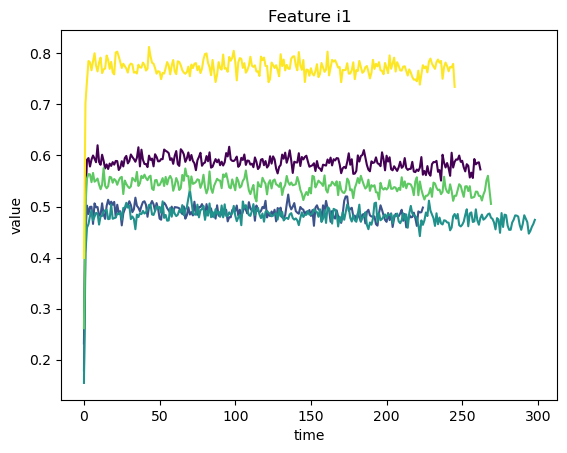

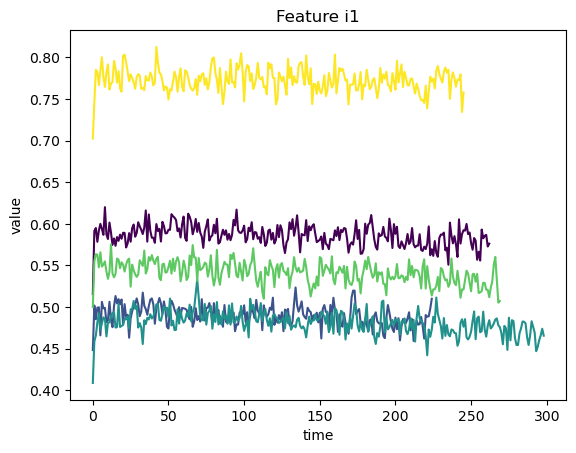

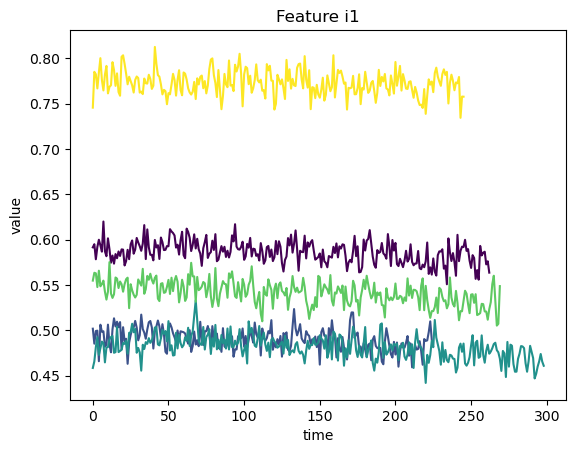

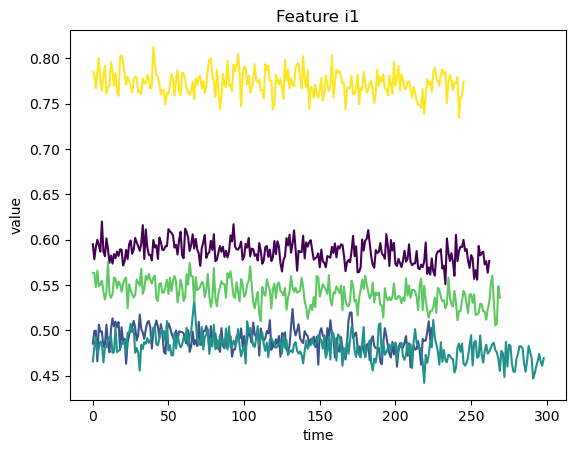

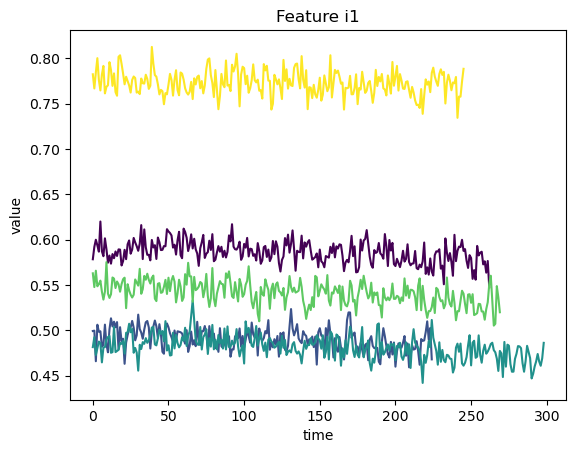

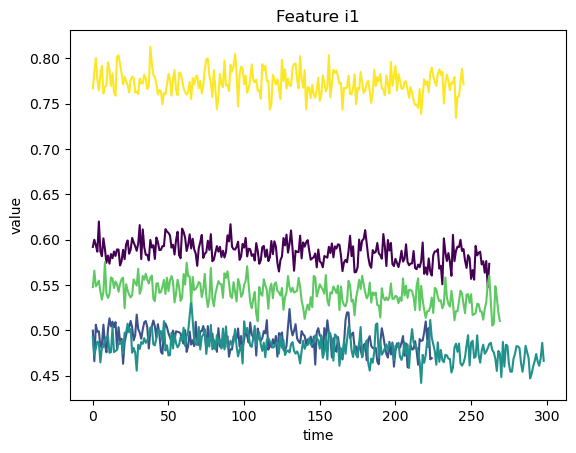

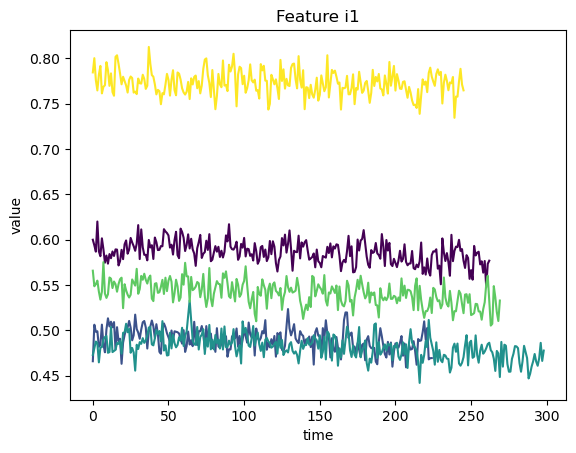

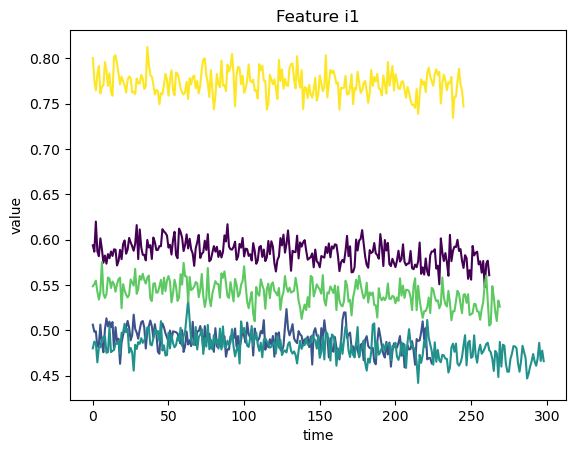

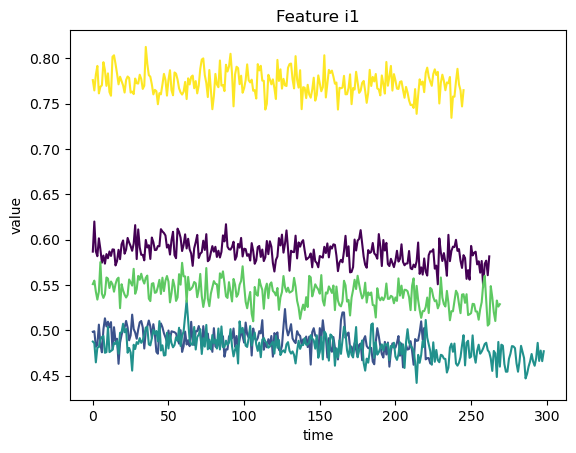

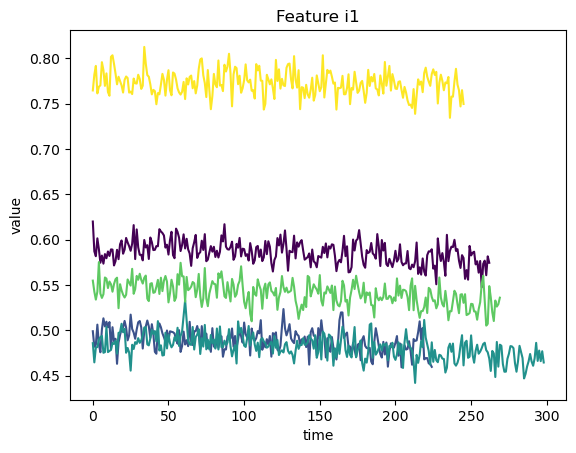

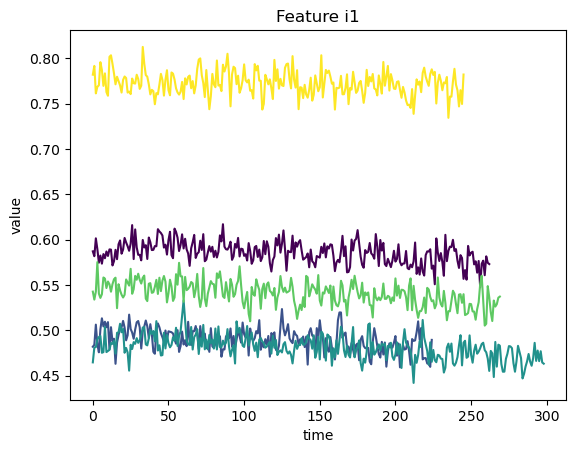

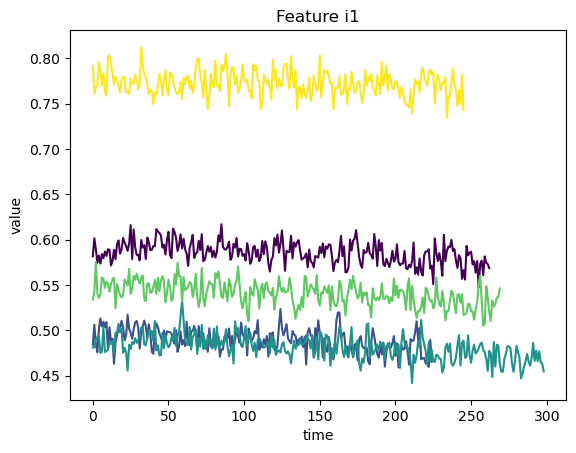

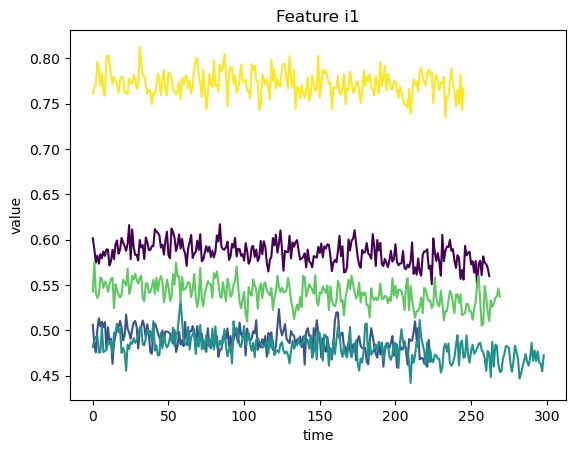

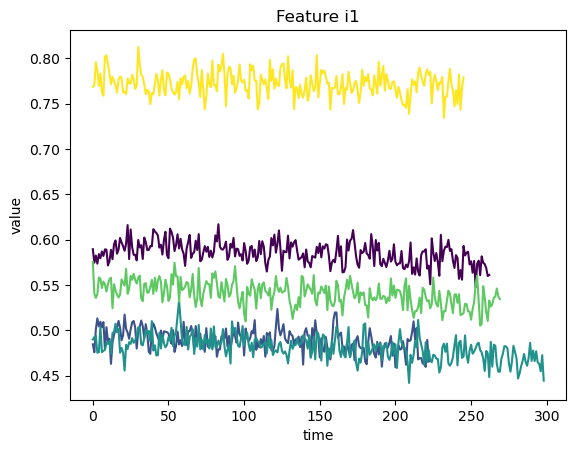

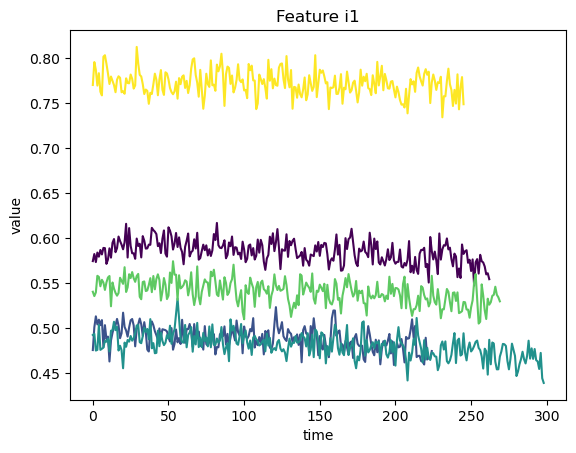

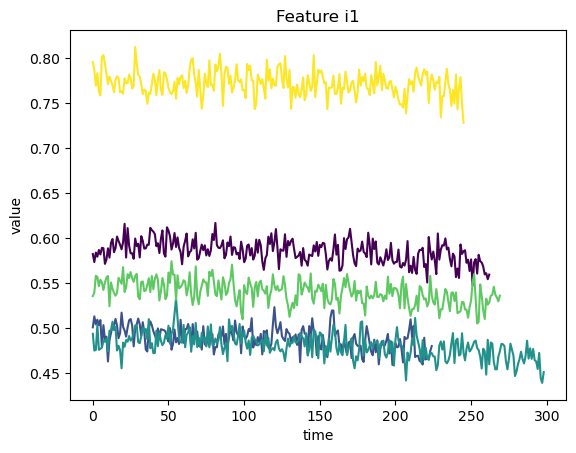

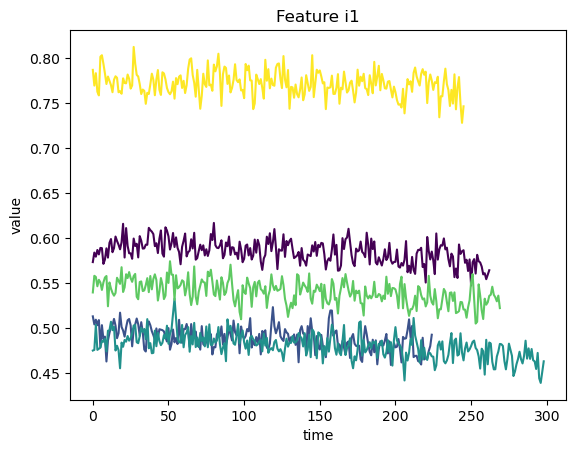

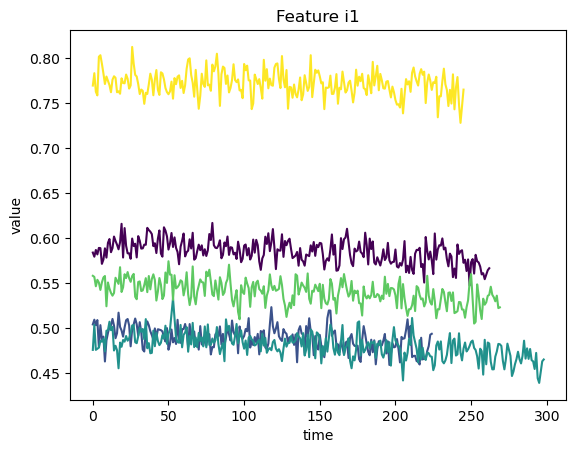

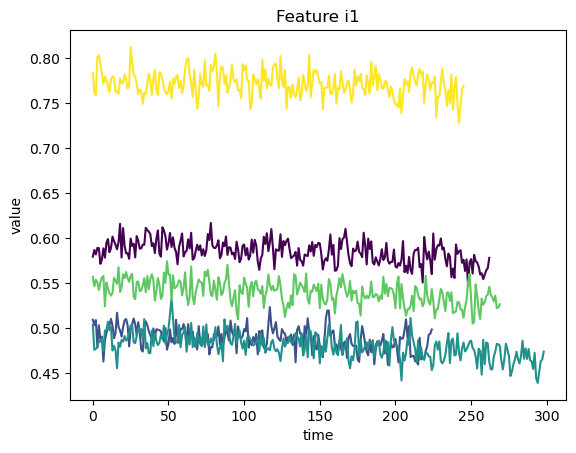

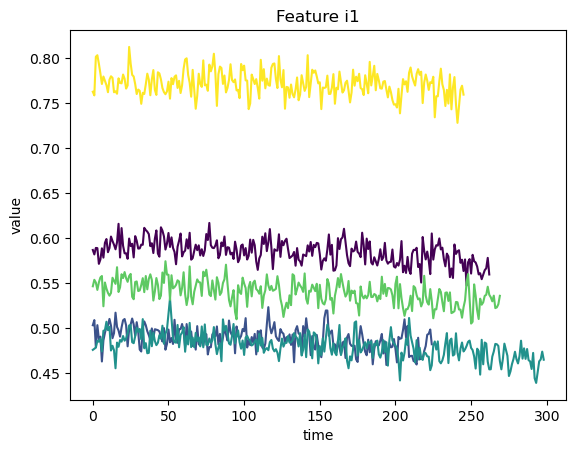

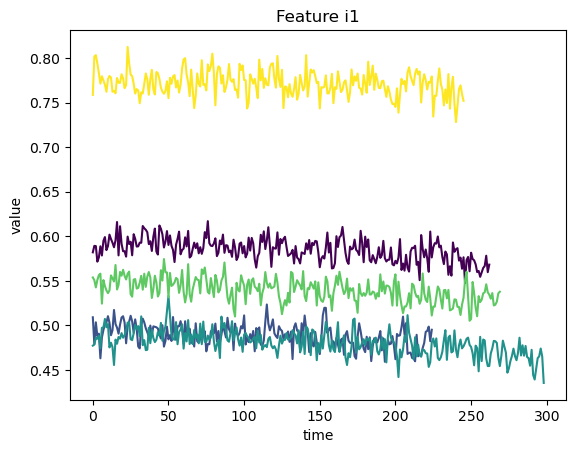

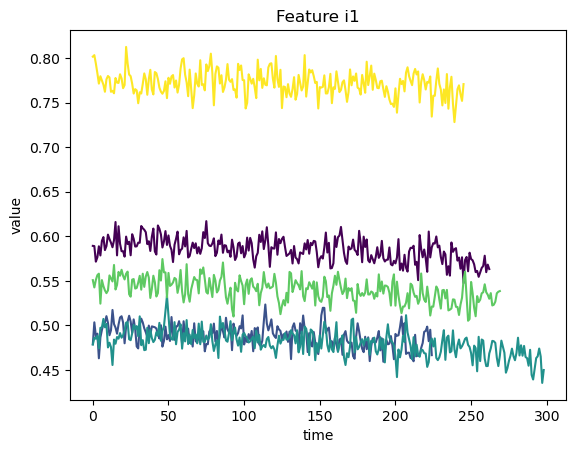

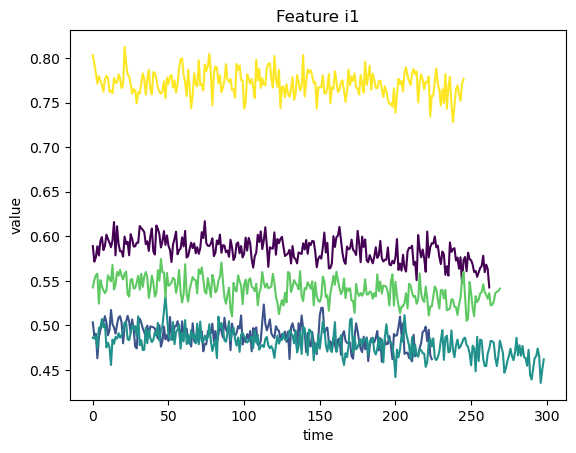

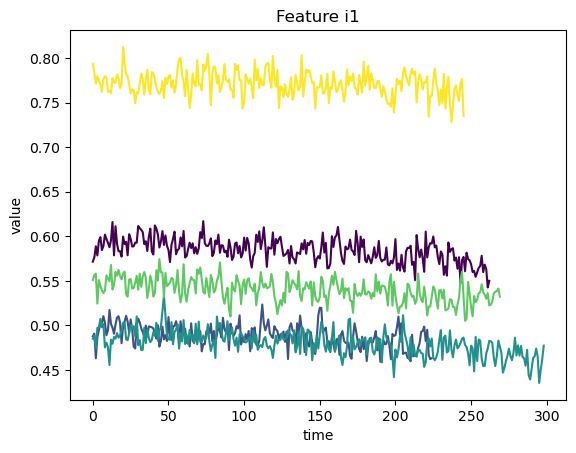

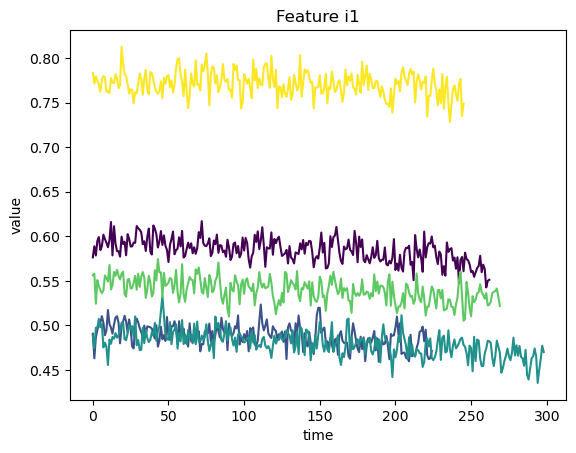

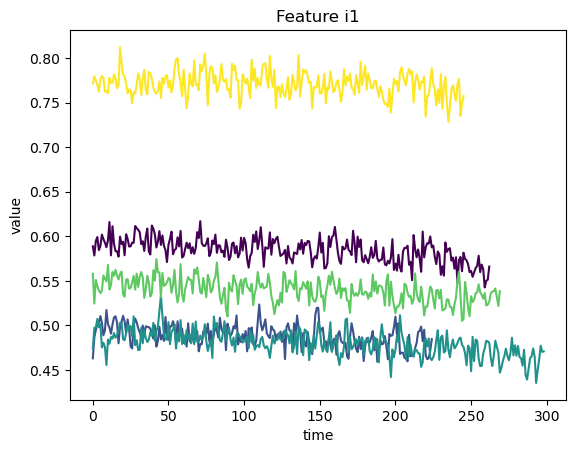

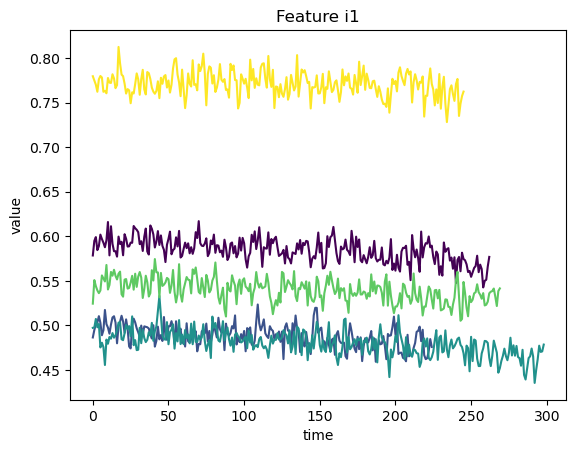

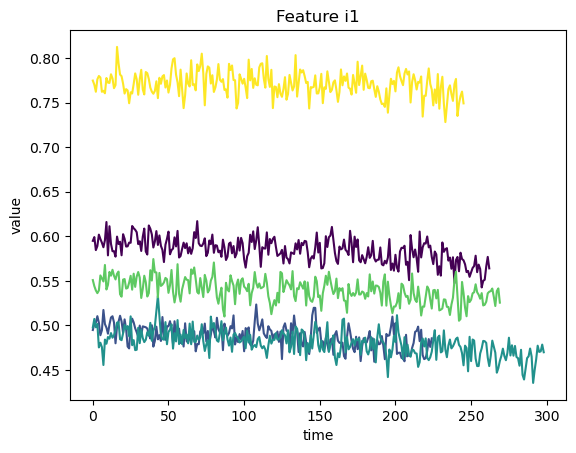

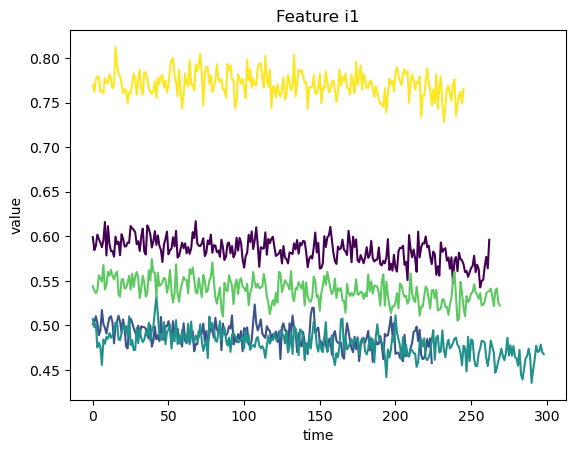

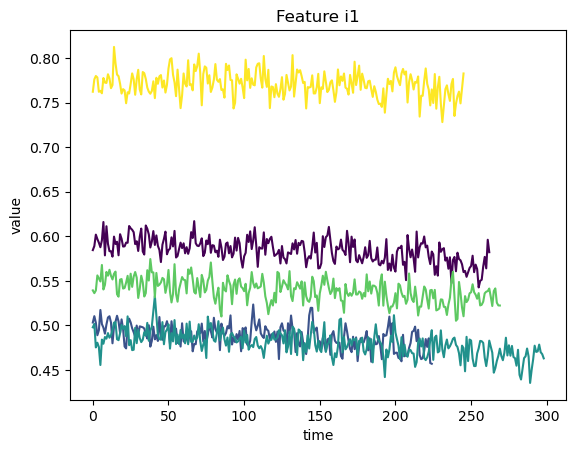

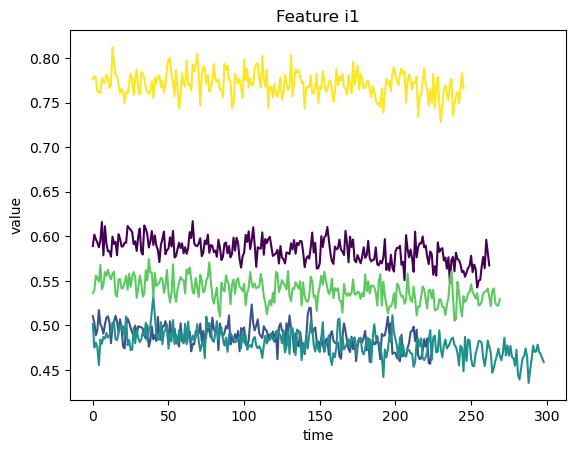

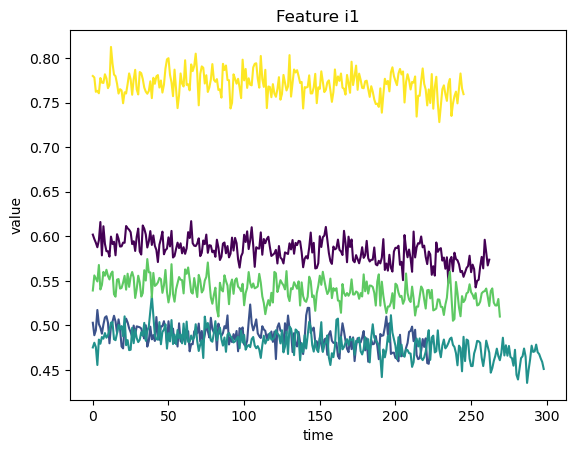

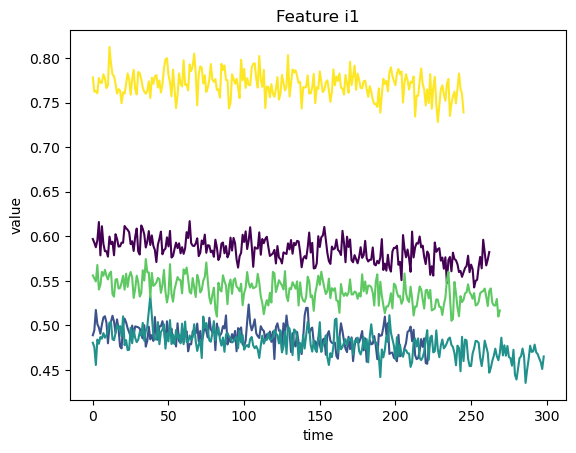

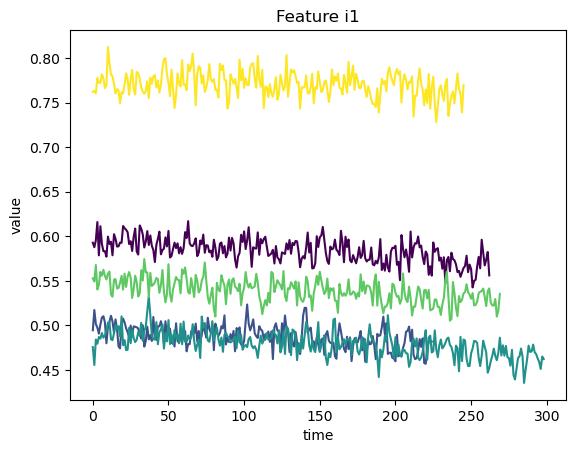

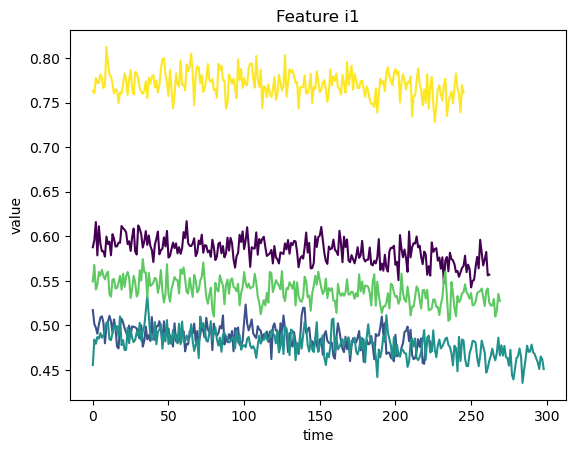

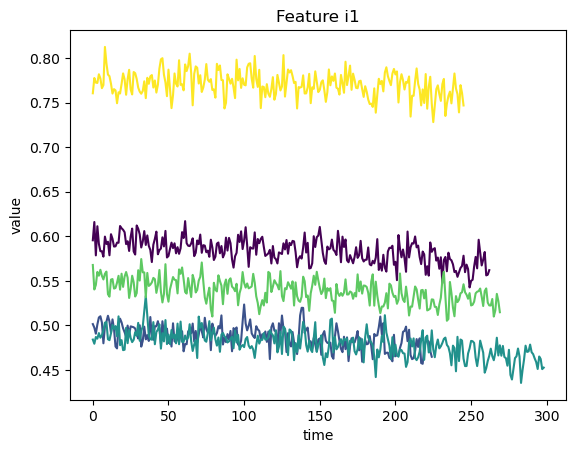

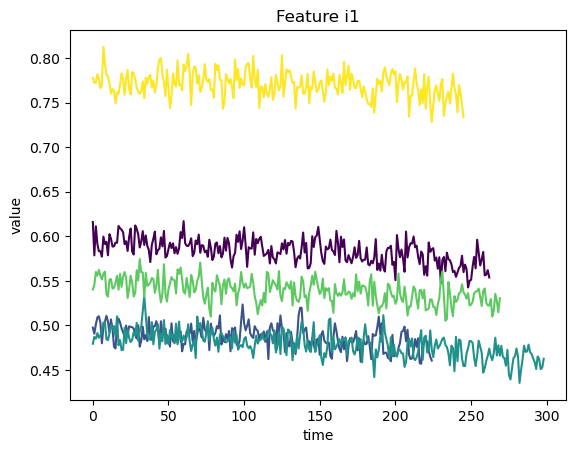

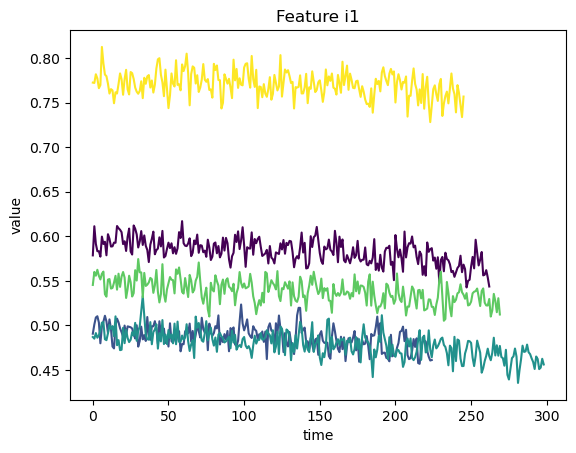

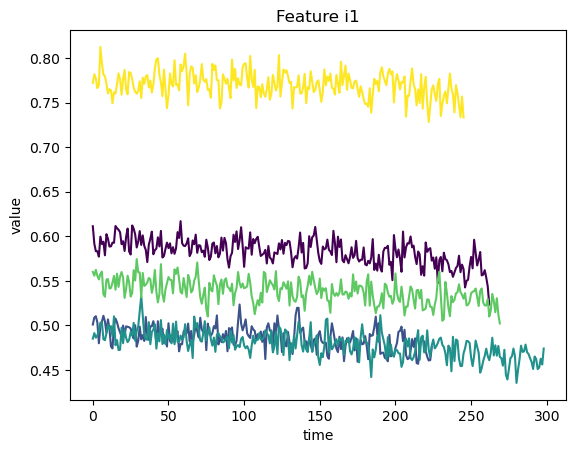

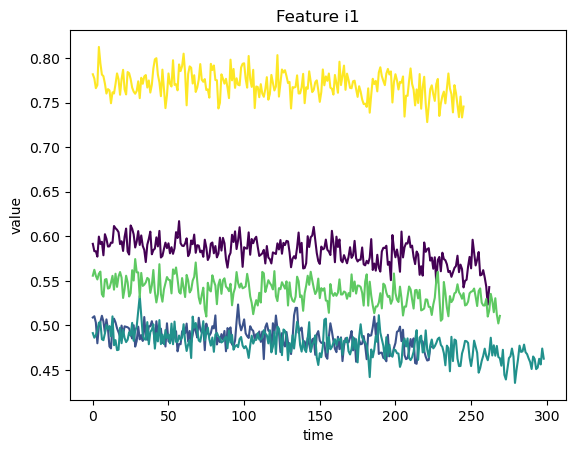

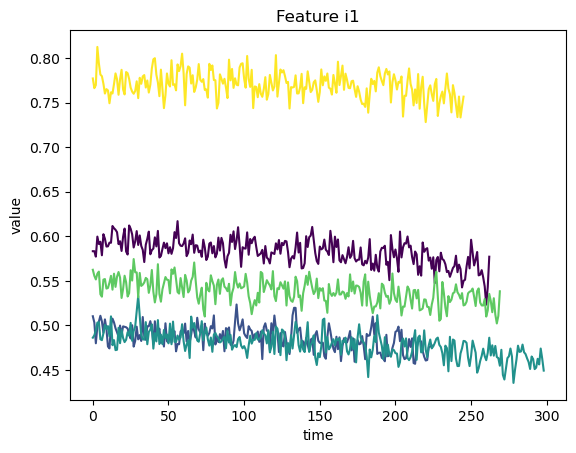

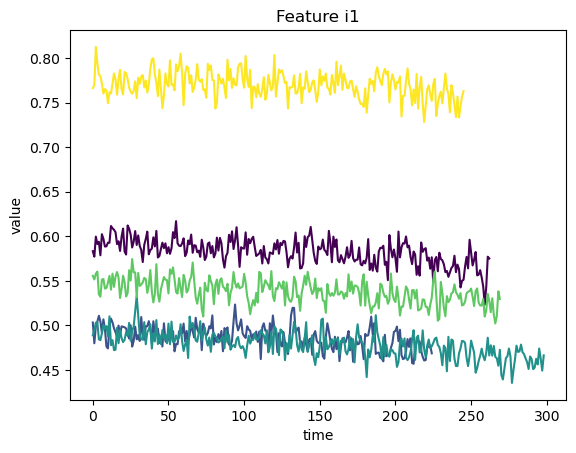

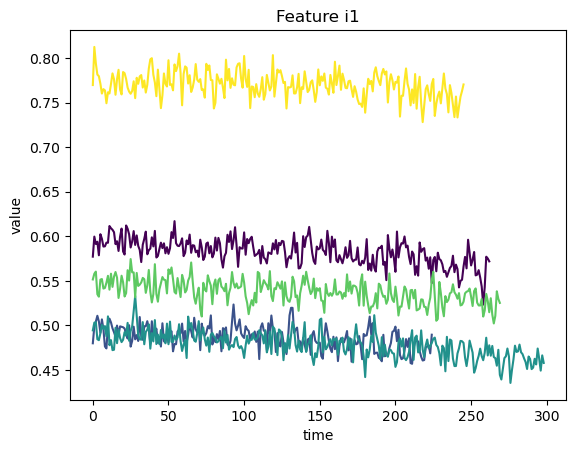

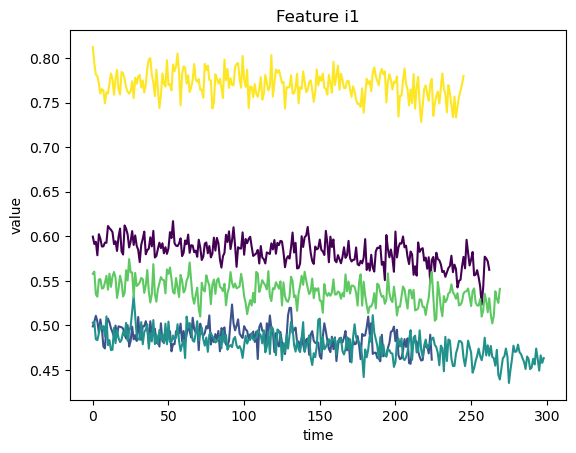

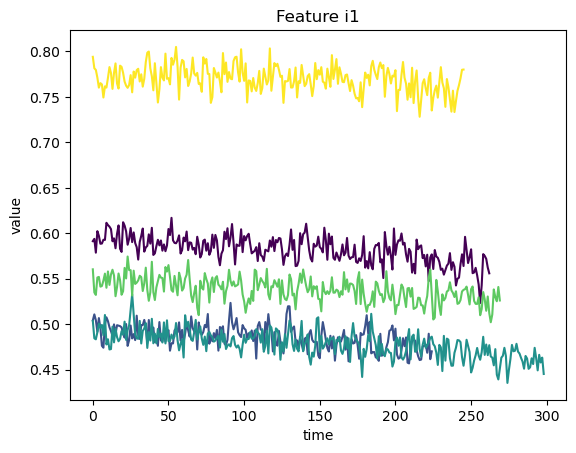

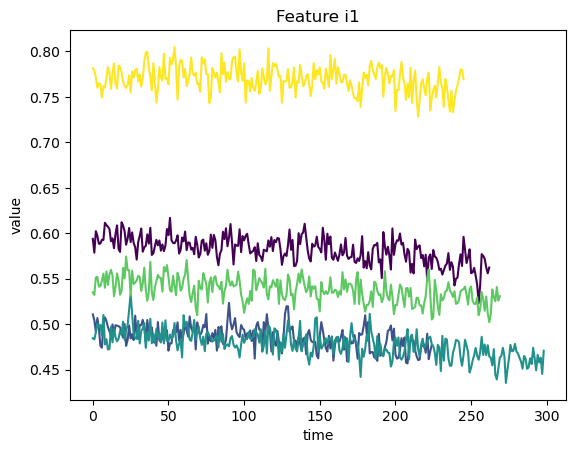

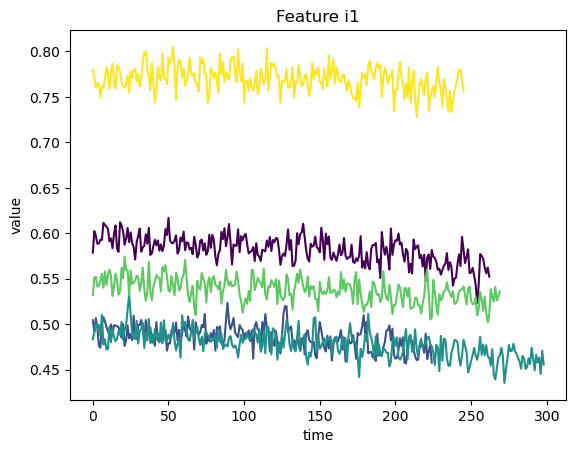

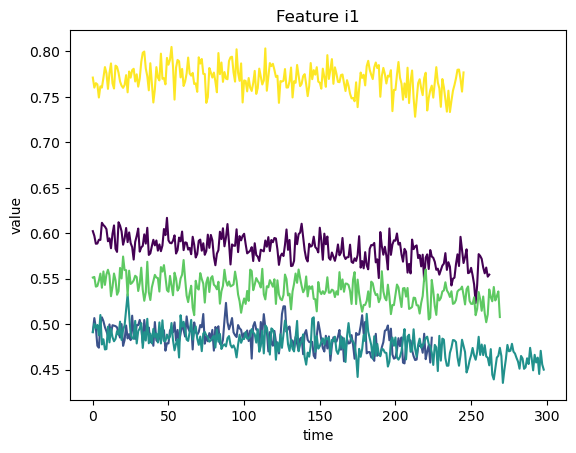

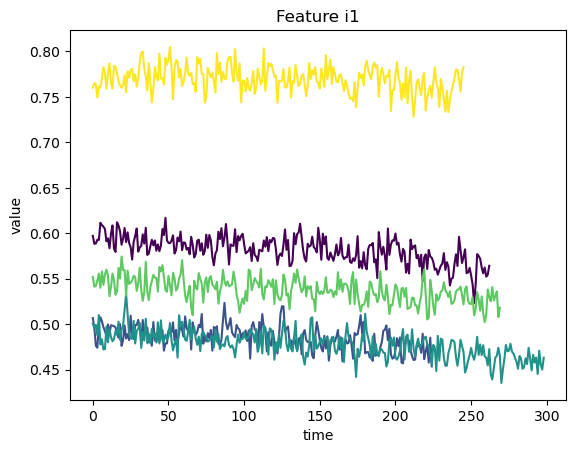

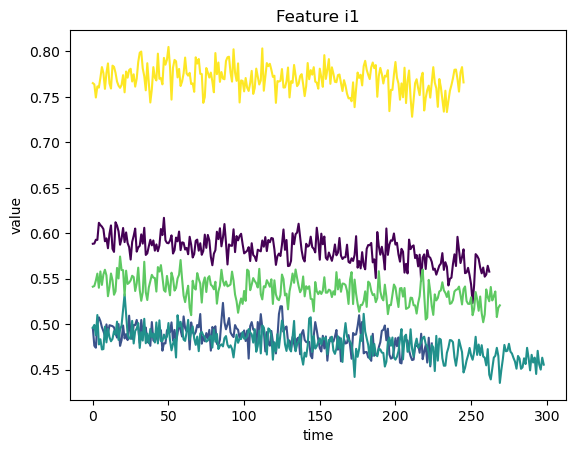

In [26]:
i=0
for t in range(50):
    X_sep=sys_separation(test_loader.dataset.var['X'][:,t,[i]],test_dataset.sys_array,aligned='left')

    plot_features(X_sep[:5],labels=test_loader.dataset.labels['X'])

In [27]:
test_loader.dataset.var['X'].shape

(13376, 51, 4)